In [1]:
!python --version

Python 3.7.13


**Julien VALENTIN**, **mars 2022**, d'après

> [Machine learning in Python with scikit-learn](https://www.fun-mooc.fr/fr/cours/machine-learning-python-scikit-learn/) d'I.N.R.I.A sur [F.U.N](https://www.fun-mooc.fr/fr/).

### Import et exploration

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100

### Modélisation par Decision Tree Regressor

In [3]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

### Sur-apprentissage vs sous-apprentissage

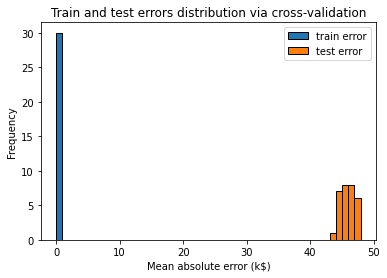

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

### Courbes de validation et impact de la profondeur de l'arbre

CPU times: user 863 ms, sys: 48.3 ms, total: 912 ms
Wall time: 30.2 s


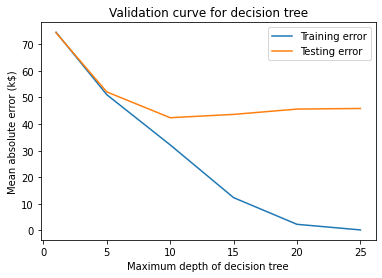

In [5]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

On remarque ici les trois zones, respectivement sous-apprentissage, puis bon apprentissage, et enfin sur-apprentissage.

# Second exemple

In [6]:
import pandas as pd

blood_transfusion = pd.read_html("https://github.com/INRIA/scikit-learn-mooc/blob/57f2e69a976136a9d1f9409b69ef0d6b3509903c/datasets/blood_transfusion.csv")[0]
blood_transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  0 non-null      float64
 1   Recency     748 non-null    int64  
 2   Frequency   748 non-null    int64  
 3   Monetary    748 non-null    int64  
 4   Time        748 non-null    int64  
 5   Class       748 non-null    object 
dtypes: float64(1), int64(4), object(1)
memory usage: 35.2+ KB


In [7]:
data = blood_transfusion.drop(columns=["Unnamed: 0", "Class"])
target = blood_transfusion["Class"]

### Modélisation par `SVM`

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC())

### Etude de la généralisation par schéma `ShuffleSplit`

In [9]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(random_state=0)
cv_results = cross_validate(model, data, target, cv=cv, n_jobs=2)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.035595,0.005673,0.680000
1,0.046071,0.005375,0.746667
2,0.036437,0.005573,0.786667
3,0.038745,0.005478,0.800000
4,0.045981,0.006437,0.746667
5,0.038240,0.011776,0.786667
6,0.047163,0.010648,0.800000
7,0.042927,0.005663,0.826667
8,0.042311,0.005465,0.746667
9,0.029778,0.003603,0.733333


In [10]:
print(
    f"Accuracy score of our model:\n"
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
)

Accuracy score of our model:
0.765 +/- 0.043


### Impact de l'hyper-paramètre $\gamma$

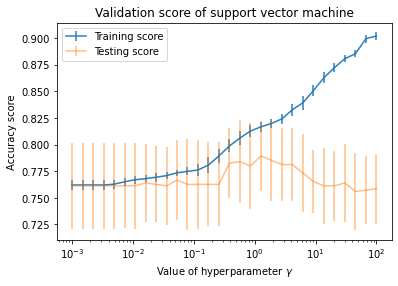

In [11]:
import numpy as np
from sklearn.model_selection import validation_curve

gammas = np.logspace(-3, 2, num=30)
param_name = "svc__gamma"
train_scores, test_scores = validation_curve(
    model, data, target, param_name=param_name, param_range=gammas, cv=cv,
    n_jobs=2)

plt.errorbar(
    gammas,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    alpha=0.95,
    label="Training score",
)
plt.errorbar(
    gammas,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    alpha=0.5,
    label="Testing score",
)
plt.legend()

plt.xscale("log")
plt.xlabel(r"Value of hyperparameter $\gamma$")
plt.ylabel("Accuracy score")
_ = plt.title("Validation score of support vector machine")

### Impact du nombre d'expériences d'apprentissage

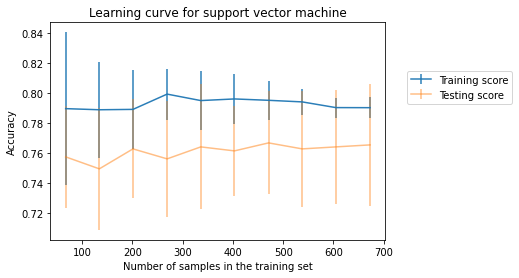

In [12]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1, num=10)
results = learning_curve(
    model, data, target, train_sizes=train_sizes, cv=cv, n_jobs=2)
train_size, train_scores, test_scores = results[:3]

plt.errorbar(
    train_size,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    alpha=0.95,
    label="Training score",
)
plt.errorbar(
    train_size,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    alpha=0.5,
    label="Testing score",
)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")

plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
_ = plt.title("Learning curve for support vector machine")